# Breast Cancer Diagnosis
## Import packages/modules

In [1]:
import sys
sys.path.append('/Users/c.kieslich/Box Sync/Research/featureSelection/')

from mistic.svmSet import svmSet
from mistic.cvSet import cvSet 
from mistic.utility import combined_rank, kernelWrapper, score_svc, perDiff, paramSet

import matplotlib.pyplot as plt   
import numpy as np
import pandas as pd
import copy

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

## Import dataset

In [2]:
# Import dataset
dataTable = pd.read_csv("wdbc.data", sep = ",",header=None) 
properties = ["Radius","Texture","Perimeter","Area","Smoothness","Compactness","Concavity","Concave Points","Symmetry","Fractal Dimension"]
names = ["ID", "Diagnosis"]+[p+" mean" for p in properties]+[p+" SE" for p in properties]+[p+" worst" for p in properties]
dataTable.columns = pd.Index(names)
dataTable

,ID,Diagnosis,Radius mean,Texture mean,Perimeter mean,Area mean,Smoothness mean,Compactness mean,Concavity mean,Concave Points mean,...,Radius worst,Texture worst,Perimeter worst,Area worst,Smoothness worst,Compactness worst,Concavity worst,Concave Points worst,Symmetry worst,Fractal Dimension worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


## Scale data and setup test set

In [3]:
X = dataTable.copy()
X.drop(columns=['ID','Diagnosis'],inplace=True)
scaler = StandardScaler()
scaler.fit(X)

X_all = scaler.transform(X)
y_all = dataTable.iloc[:,1]

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    stratify = y_all, 
                                                    random_state= 0, 
                                                    test_size= 1/5)

## Define cross validation sets

In [4]:
cv_set = cvSet(X = X_train, y = y_train.values)
cv_set.classification(num_sets = 5)

## Initialize SVC model and parameter grids

In [5]:
svc = SVC(kernel = 'precomputed', class_weight="balanced", probability=False, tol = 1e-12)

C_range = [2**x for x in range(-2,5)]
gamma_range = [2**x for x in range(-9,1)]

parameter_grid = []
for cost in C_range:
    for gamma in gamma_range:
        parameter_grid.append(paramSet(model={"C": cost},kernel={"gamma": gamma}))

## Feature Selection

In [6]:
kernel_type = "rbf"

rank_weights = [0,0.25,0.50,0.75,1]

svm_set_ranks = []
for i in range(len(rank_weights)):
    print(f"Rank weight: {rank_weights[i]:.2f}")
    svm_set_ranks.append(svmSet(svc, cv_set,
                                score_method = score_svc().score,
                                kernel = kernelWrapper(type = kernel_type),
                                separate_feature_sets = True,
                                separate_parameters = True))

    svm_set_ranks[i].greedy_backward_selection(parameter_grid = parameter_grid,
                                           reduction_factor = 0,
                                           feature_ranker = combined_rank(weight=rank_weights[i]).compute,
                                           set_for_rank = "sample")

Rank weight: 0.00
Number of Features: 30, Score: 0.995
Number of Features: 29, Score: 0.995
Number of Features: 28, Score: 0.995
Number of Features: 27, Score: 0.992
Number of Features: 26, Score: 0.990
Number of Features: 25, Score: 0.990
Number of Features: 24, Score: 0.990
Number of Features: 23, Score: 0.989
Number of Features: 22, Score: 0.989
Number of Features: 21, Score: 0.990
Number of Features: 20, Score: 0.990
Number of Features: 19, Score: 0.991
Number of Features: 18, Score: 0.990
Number of Features: 17, Score: 0.986
Number of Features: 16, Score: 0.977
Number of Features: 15, Score: 0.980
Number of Features: 14, Score: 0.983
Number of Features: 13, Score: 0.982
Number of Features: 12, Score: 0.985
Number of Features: 11, Score: 0.980
Number of Features: 10, Score: 0.982
Number of Features: 9, Score: 0.980
Number of Features: 8, Score: 0.976
Number of Features: 7, Score: 0.974
Number of Features: 6, Score: 0.970
Number of Features: 5, Score: 0.972
Number of Features: 4, Sc

## Feature Selection Performance Curves

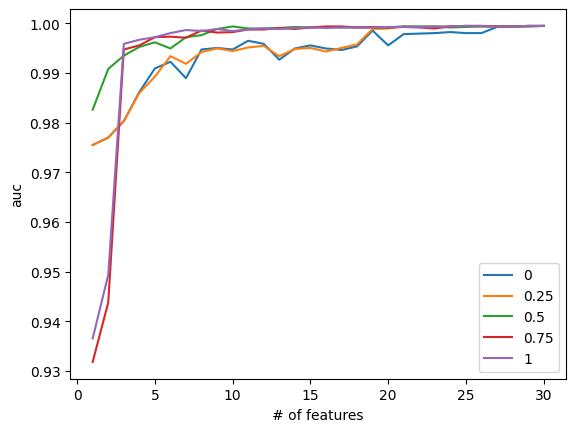

In [7]:
for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="auc")

plt.legend(labels=rank_weights)

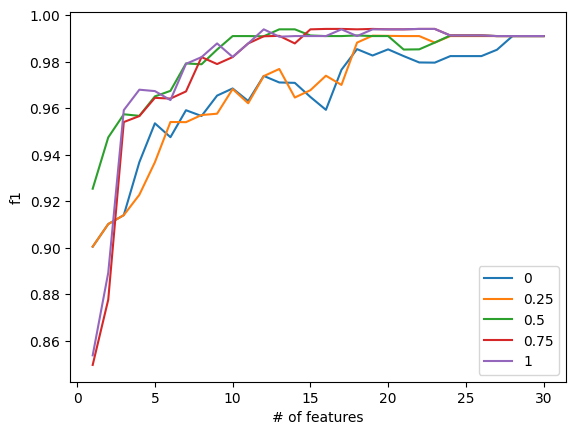

In [8]:
for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="f1")

plt.legend(labels=rank_weights)

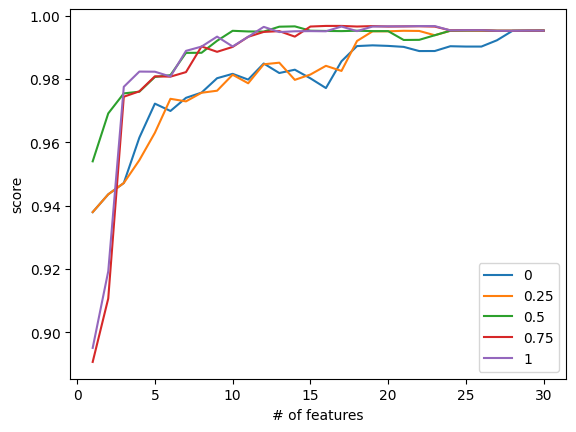

In [9]:
for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="score")

plt.legend(labels=rank_weights)

## Feature Selection Enrichment Scores

In [21]:
enrich_score = []
for i in range(len(rank_weights)):
    enrich_score.append(svm_set_ranks[i].enrichment_score())

selected_run = 4 #enrich_score.index(max(enrich_score))

enrich_score

[0.9479279877388935,
 0.9489545917235359,
 0.9574969206877417,
 0.9545031021370652,
 0.9555558766013115]

## Pairplots and scatter plot of top 3 features

/Users/c.kieslich/miniforge3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



Text(0.5, 1.08, 'Rank weight: 1.00')

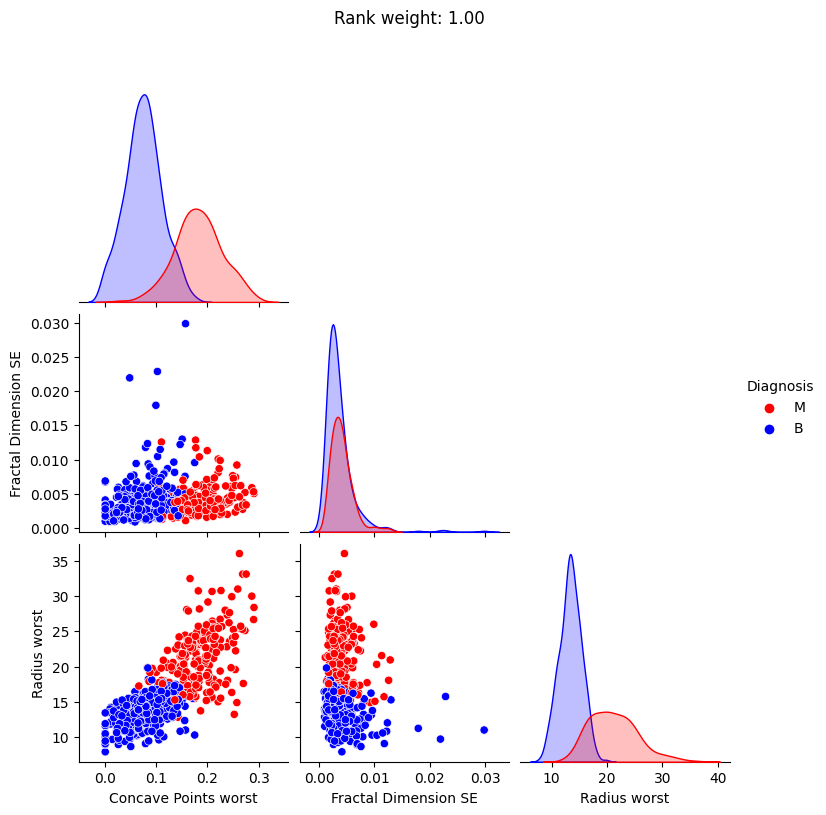

In [22]:
import plotly.express as px
from seaborn import pairplot, clustermap, load_dataset

selected_model = 0
top_features = X.columns[svm_set_ranks[selected_run].sorted_features[selected_model].astype(int)[0:3]].values
fig = pairplot(dataTable[np.append(top_features, 'Diagnosis')],
         hue="Diagnosis", corner=True, palette={"M":"red","B":"blue"})
fig.fig.suptitle(f"Rank weight: {rank_weights[selected_run]:.2f}", y=1.08)

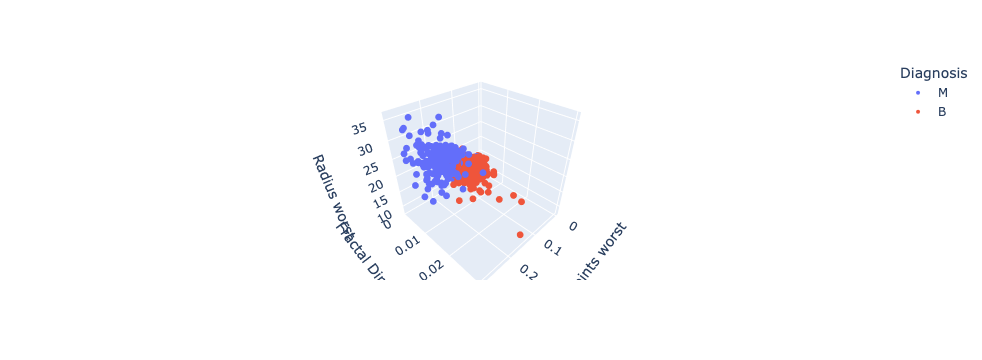

In [23]:
fig = px.scatter_3d(dataTable, x=top_features[0], y=top_features[1], z=top_features[2],
          color='Diagnosis')
fig.update_traces(marker_size = 4)
fig.show()

## Best Model Blind Set Performance

In [24]:
from sklearn.metrics import roc_auc_score, confusion_matrix

decision_values = svm_set_ranks[selected_run].decision_function(X_test)
y_pred = svm_set_ranks[selected_run].predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*precision*recall/(precision+recall)

auc = roc_auc_score(y_test, decision_values)
            
blind_results = {'rank_weights': rank_weights[selected_run], 'number_features': len(svm_set_ranks[selected_run].features), 'f1': f1, 'auc': auc}

blind_results

{'rank_weights': 1,
 'number_features': 5,
 'f1': 0.9411764705882352,
 'auc': 0.9917328042328042}

## Integrated Gradients Atrributions

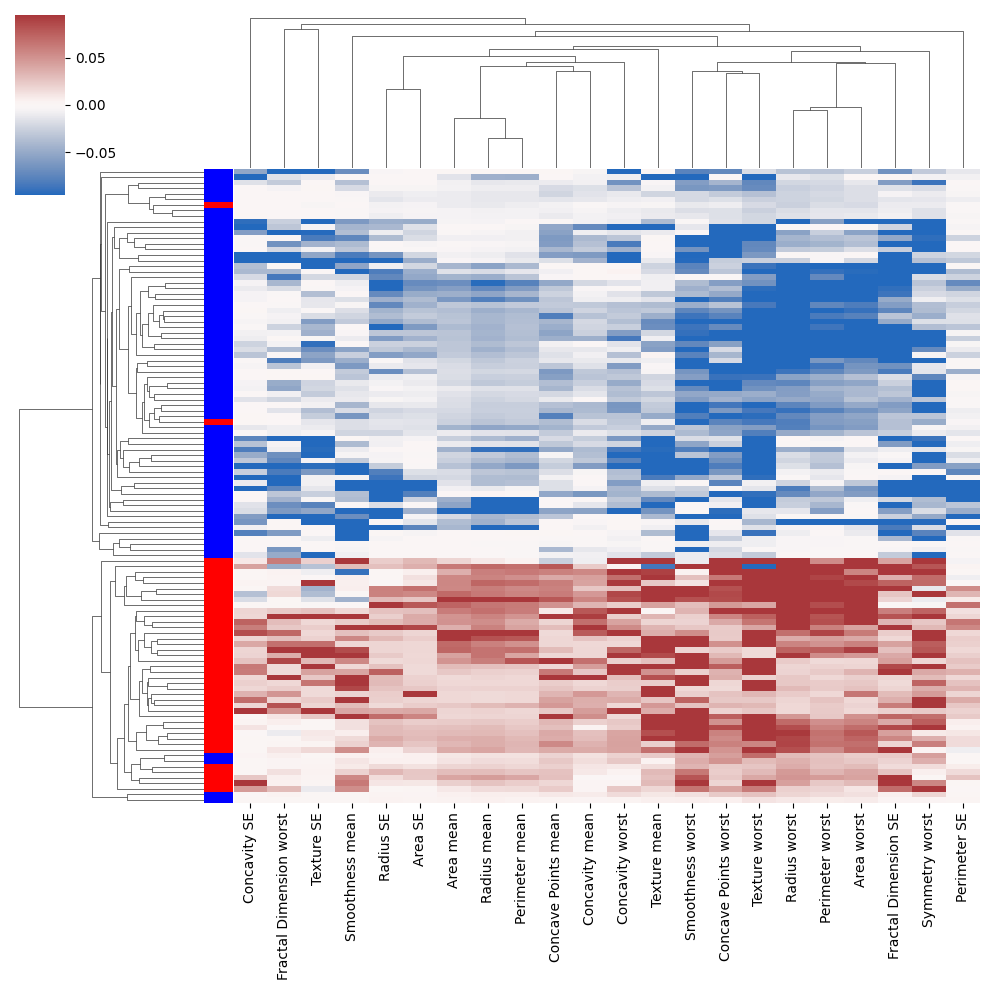

In [25]:
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list, fcluster

linkMeth = "average"

IG = svm_set_ranks[selected_run].integrated_gradient(X_test, model_index = selected_model)

IGtable = pd.DataFrame(IG,columns=X.columns[svm_set_ranks[selected_run].features[selected_model]])

distMatCol = perDiff(IGtable)
hcCol = linkage(distMatCol, method=linkMeth,optimal_ordering=True)

tr_IGtable = IGtable.transpose()
distMatRow = perDiff(tr_IGtable)
hcRow = linkage(distMatRow, method=linkMeth,optimal_ordering=True)

color_val = max(np.abs((np.mean(IG)-np.std(IG), np.mean(IG)+np.std(IG))))
clustermap(IGtable, 
           yticklabels=False,
           cmap="vlag", vmin=-color_val, vmax=color_val,
           row_linkage=hcRow, col_linkage=hcCol, 
           row_colors=[["red","blue"][int(l=="B")+0] for l in y_test])

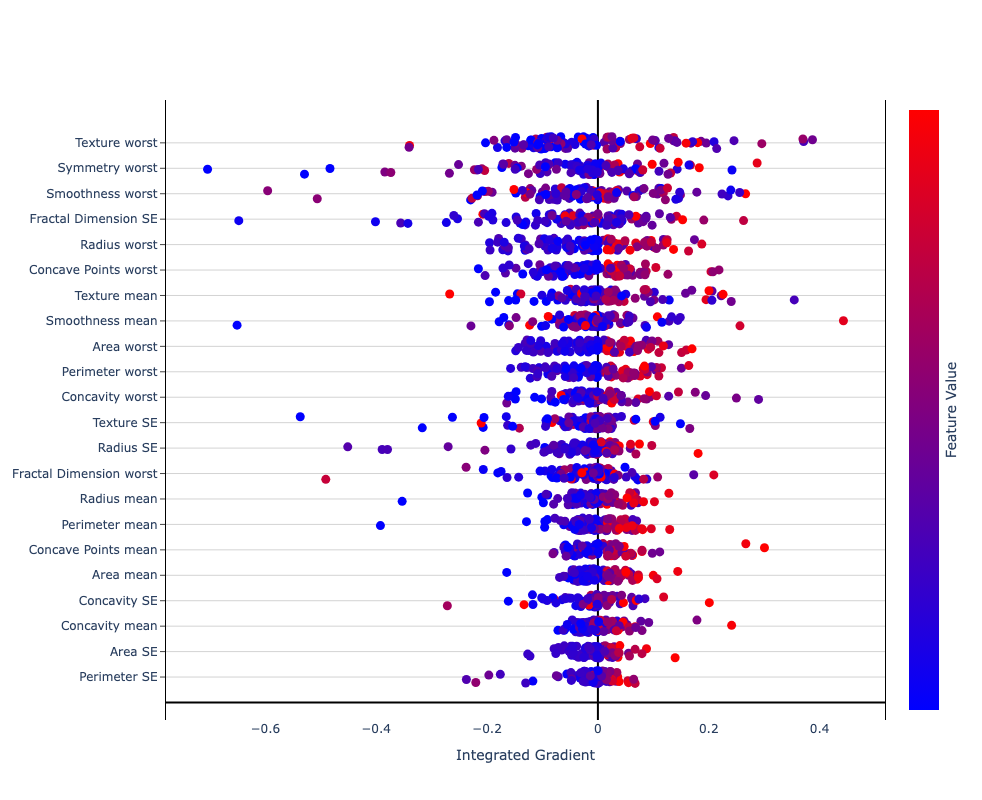

In [26]:
import plotly.graph_objects as go
import plotly.express as px
import numpy as np

features = svm_set_ranks[selected_run].features[selected_model]
df_X_test = pd.DataFrame(X_test[:,features],columns = IGtable.columns)
N = len(IGtable)

fig = go.Figure()
fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=800,
    height=800,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = "Integrated Gradient",
)

fig.update_xaxes(
    zeroline=True,
    zerolinecolor="black",
    )
    
fig.update_yaxes(
    zeroline=True,
    zerolinecolor="black",
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

feature_order = np.argsort(np.sum(abs(IG),axis=0))

y_val = 1
for f in feature_order:
    fig.add_trace(go.Scatter(
        x = IGtable.iloc[:,f], 
        y = y_val + np.random.rand(N)*0.5 - 0.25,
        mode = 'markers',
        marker = dict(size=9,
                      color = df_X_test.iloc[:,f],
                      coloraxis = "coloraxis",
                     ),
        name=IGtable.columns[f],
    ))
    y_val += 1


fig.update_layout(showlegend=False, coloraxis_showscale=True)
fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text="Feature Value",side = "right"),
                    cmin = -1, cmax = 2)
fig.update_yaxes(tickvals=[i for i in range(1,IGtable.shape[1]+1)], ticktext=IGtable.columns[feature_order])
fig.show() 

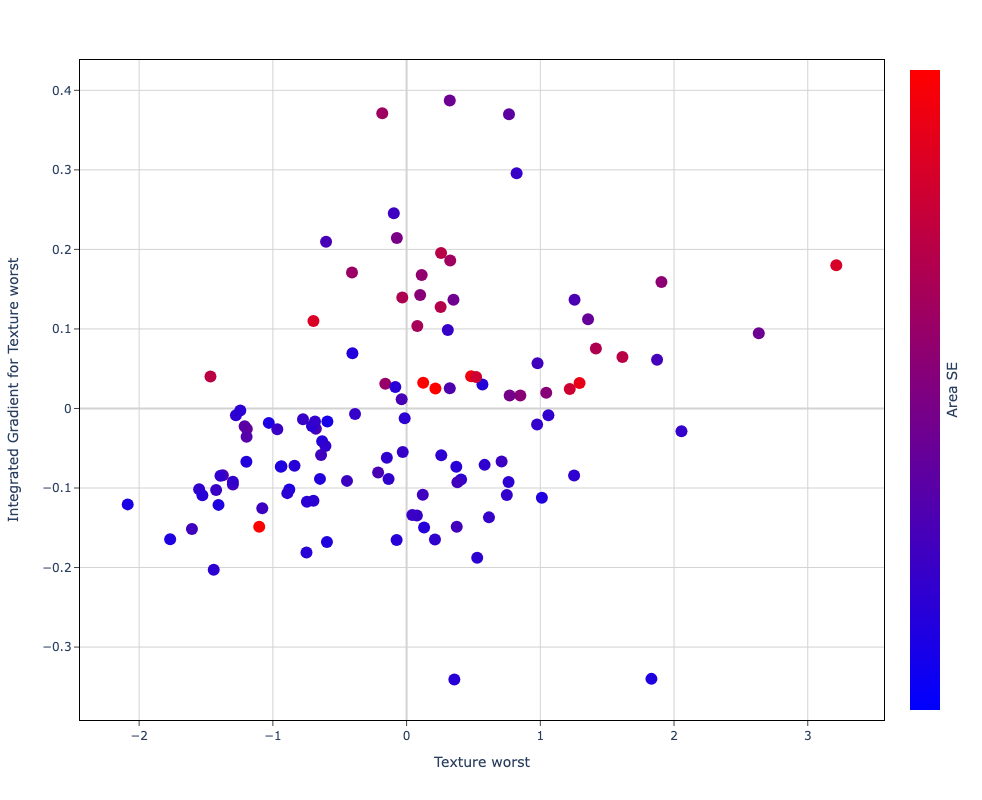

In [27]:
feat_1 = "Texture worst"
feat_2 = "Area SE"

fig = px.scatter(x = df_X_test[feat_1], y = IGtable[feat_1], color = df_X_test[feat_2])
fig.update_traces(marker=dict(size=12))

fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=800,
    height=800,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = feat_1,
    yaxis_title = "Integrated Gradient for " + feat_1,
)

fig.update_xaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
    )
    
fig.update_yaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text=feat_2,side = "right"),
                    cmin = -1, cmax = 2)

fig.show()

## Reduce models to only include support vectors

In [28]:
svm_set_ranks[selected_run]._reduce_models(parameter_grid)

In [29]:
decision_values = svm_set_ranks[selected_run].decision_function(X_test)
y_pred = svm_set_ranks[selected_run].predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*precision*recall/(precision+recall)
auc = roc_auc_score(y_test, decision_values)
            
blind_results = {'rank_weights': rank_weights[selected_run], 'number_features': len(svm_set_ranks[selected_run].features), 'f1': f1, 'auc': auc}

blind_results

{'rank_weights': 1,
 'number_features': 5,
 'f1': 0.9411764705882352,
 'auc': 0.9920634920634921}

In [30]:
svm_set_ranks[selected_run]._reset_X_ind(parameter_grid)

In [31]:
decision_values = svm_set_ranks[selected_run].decision_function(X_test)
y_pred = svm_set_ranks[selected_run].predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*precision*recall/(precision+recall)
auc = roc_auc_score(y_test, decision_values)
            
blind_results = {'rank_weights': rank_weights[selected_run], 'number_features': len(svm_set_ranks[selected_run].features), 'f1': f1, 'auc': auc}

blind_results

{'rank_weights': 1,
 'number_features': 5,
 'f1': 0.9411764705882352,
 'auc': 0.9917328042328042}